## Imports

In [16]:
from pmdlearn import MDFeaturizer, Features
from os.path import join as jn
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rc('figure', fc='white')
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.scatterpoints'] = 1
plt.style.use('classic')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

## Load the input trajectories

In [2]:
INPUT_FOLDER = "/home/aria/landslide/MDRUNS/IVAN_IGPS/" # To modify
# Generates a list of tuples with apo 1..4 and prfar 1..4
system_replica = list(product(['apo', 'prfar'], range(1, 5))) 
print(system_replica)

traj_list = [jn(INPUT_FOLDER, 'prot_{}_sim{}_s10.dcd').format(system, replica) 
             for system, replica in system_replica]
topo = jn(INPUT_FOLDER, 'prot.prmtop')


[('apo', 1), ('apo', 2), ('apo', 3), ('apo', 4), ('prfar', 1), ('prfar', 2), ('prfar', 3), ('prfar', 4)]


## Compute all contacts and then concatenate them together

In [3]:
##### We initialize the contacts as None
contacts = None 
for i, traj in enumerate(traj_list):
    system, replica = system_replica[i]
    universe = MDFeaturizer(topo, traj=traj, label=system, replica=replica, align=False)
    _contacts = universe.contacts()
    if contacts is None:
        contacts = _contacts
    else:
        contacts += _contacts


/home/aria/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/TOPParser.py:288: UserWarning: ATOMIC_NUMBER record not found, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)
100%|██████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.57it/s]


The Features class stores relevant information about the Features in two separate attributes:
- indices: represents the contacts indices (by default 0-based), a 2 x n_contacts matrix
- values: represents the values for each contact, a n_frames x n_contacts matrix

In [4]:
print(contacts.indices, contacts.indices.shape, contacts.values, contacts.values.shape)

[[  0   1]
 [  0   2]
 [  0   3]
 ...
 [451 452]
 [451 453]
 [452 453]] (4408, 2) [[28.  3.  0. ... 23.  4. 23.]
 [29.  5.  0. ... 23.  4. 21.]
 [28. 15.  2. ... 24.  1. 24.]
 ...
 [29.  4.  1. ... 23. 19. 46.]
 [22.  3.  0. ... 23. 20. 31.]
 [23.  4.  0. ... 24.  2. 36.]] (8000, 4408)


In [5]:
# We can get map automatic residue names to sort through indices more clearly

reslist = universe.get_reslist(chain_labels=('F', 'H'))
# Amber trajectories/topologies are usually awful to deal with because chains have
# been broken and renumbered so we need to work on it

chain_labels = {0: 'F', 1: 'H'}
reslist_fixed = ['{}{}:{}'.format(res[:3], int(res[3:-2])%254+int(res[3:-2])//254, chain_labels[int(res[3:-2])//254])
                 for res in reslist]
reslist_fixed

contacts.mapping(reslist)

In [6]:
print(contacts.indices)

[['MET1:F' 'LEU2:F']
 ['MET1:F' 'ALA3:F']
 ['MET1:F' 'LYS4:F']
 ...
 ['SER452:F' 'ARG453:F']
 ['SER452:F' 'ARG454:F']
 ['ARG453:F' 'ARG454:F']]


## Run Dynamical Perturbation Contact Network

In [7]:
# This performs the average for each system and each replica
dpcn = contacts.average() 
# Notice the structure of the table with node1 node2 being the nodes in contact 
# and all columns average, you don't really have a DPCN yet
dpcn

,node1,node2,apo1,apo2,apo3,apo4,prfar1,prfar2,prfar3,prfar4,apo,prfar
0,MET1:F,LEU2:F,25.587,26.633,28.047,28.347,24.809,30.108,25.067,26.835,27.15350,26.70475
1,MET1:F,ALA3:F,3.638,3.551,3.826,3.588,4.126,2.998,4.392,4.273,3.65075,3.94725
2,MET1:F,LYS4:F,0.018,0.013,0.071,0.062,0.014,0.124,0.160,0.056,0.04100,0.08850
3,MET1:F,PHE214:F,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.00000,0.00025
4,MET1:F,ASP219:F,0.000,0.000,0.000,0.000,0.000,0.011,0.003,0.000,0.00000,0.00350
...,...,...,...,...,...,...,...,...,...,...,...,...
4403,LEU451:F,ARG453:F,8.741,8.907,9.554,8.252,8.616,6.849,8.137,7.904,8.86350,7.87650
4404,LEU451:F,ARG454:F,0.768,1.400,1.031,0.742,3.762,8.280,3.091,5.673,0.98525,5.20150
4405,SER452:F,ARG453:F,29.820,27.947,28.241,28.992,29.103,28.061,26.362,28.724,28.75000,28.06250
4406,SER452:F,ARG454:F,2.459,2.223,2.076,3.106,3.313,4.516,4.993,4.001,2.46600,4.20575


In [8]:
# To make a DPCN we have to properly do the subtraction
dpcn['prfar-apo'] = dpcn['prfar'] - dpcn['apo']
# and use NetworkX to generate a network
G = nx.from_pandas_edgelist(dpcn, edge_attr='prfar-apo', source='node1', target='node2')

We can plot the network with networkx but usually it's a bad idea because it's very hard to make a nice plot

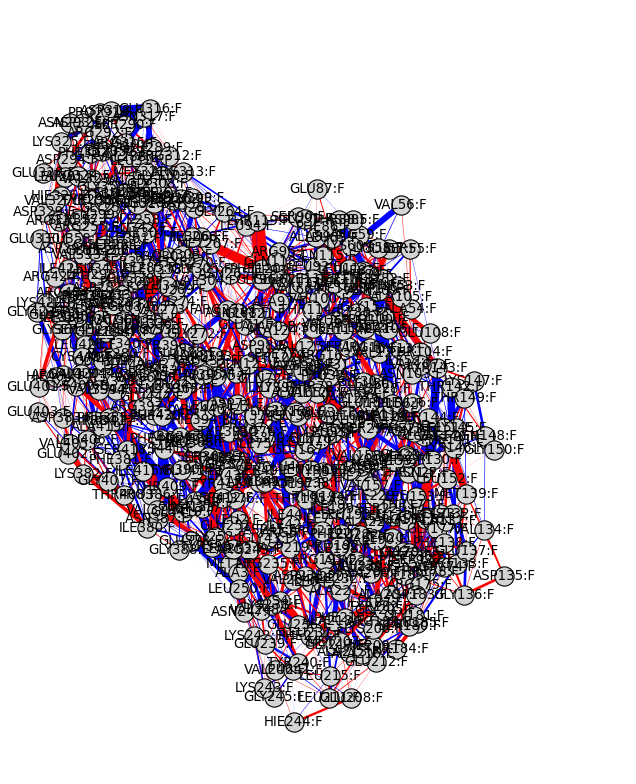

In [9]:
#Generating edge colors
edge_color = ['b' if weight <= 0 else 'r' for weight in dpcn['prfar-apo'].values]
# And edge width
edge_width = dpcn['prfar-apo'].abs().values

fig, axes = plt.subplots(1, 1, figsize=[10, 12])
nx.draw(G, with_labels=True, node_color='lightgray', width=edge_width, edge_color=edge_color)

The easiest way to visualize graphs is inside pymol (see README for more information)

In [10]:
dpcn.to_pickle('../data/dpcn.dfp') #of course you may want to change the path

We can also try to add a threshold, let's say 6

In [11]:
threshold = 6
ix = dpcn['prfar-apo'].abs() >= threshold
G = nx.from_pandas_edgelist(dpcn.loc[ix], edge_attr='prfar-apo', source='node1', target='node2')

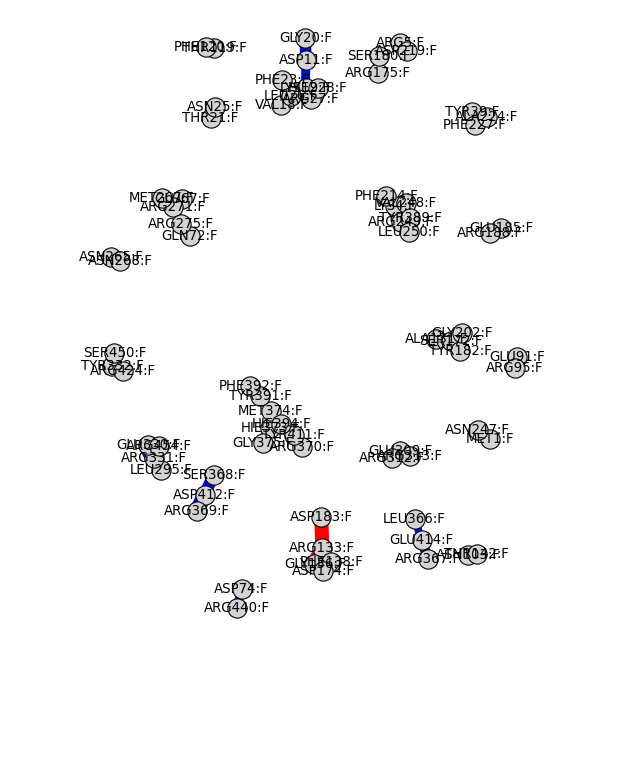

In [12]:
#Generating edge colors
edge_color = ['b' if weight <= 0 else 'r' for weight in dpcn.loc[ix]['prfar-apo'].values]
# And edge width
edge_width = dpcn.loc[ix]['prfar-apo'].abs().values

fig, axes = plt.subplots(1, 1, figsize=[10, 12])
nx.draw(G, with_labels=True, node_color='lightgray', width=edge_width, edge_color=edge_color)

## Contact Principal Component Analysis

In [13]:
cPCA = contacts.ca(n_components=2)

We can plot the first 2 PCs to verify that apo and prfar are properly separated

<AxesSubplot:xlabel='C1', ylabel='C2'>

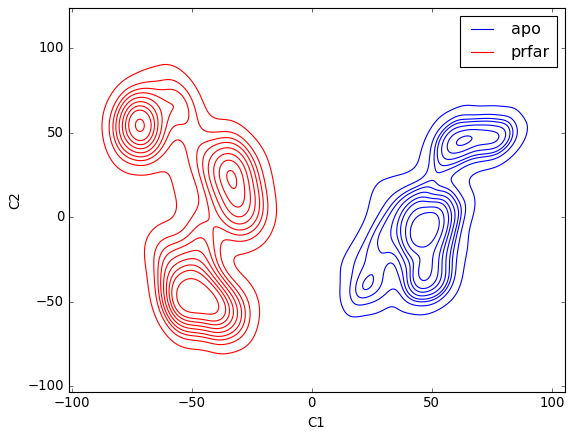

In [24]:
system = ['apo']*4000+['prfar']*4000
sns.kdeplot(data=cPCA.dataframe, x='C1', y='C2', hue=system, common_norm=False, palette=('b', 'r'))

## We can take a look at the influence of each contact in each PC

In [27]:
influences = cPCA.get_influences()
influences.to_pickle('../data/cpcn.dfp')
influences

,node1,node2,C1,C2
0,MET1:F,LEU2:F,-0.002072,0.008315
1,MET1:F,ALA3:F,-0.002118,-0.004794
2,MET1:F,LYS4:F,-0.000597,0.000322
3,MET1:F,PHE214:F,-0.000002,-0.000001
4,MET1:F,ASP219:F,-0.000043,0.000049
...,...,...,...,...
4403,LEU451:F,ARG453:F,0.011799,-0.002985
4404,LEU451:F,ARG454:F,-0.049266,0.027909
4405,SER452:F,ARG453:F,0.009363,0.013492
4406,SER452:F,ARG454:F,-0.020197,-0.005983


## Let's graph the PC1N

9.999999999999998


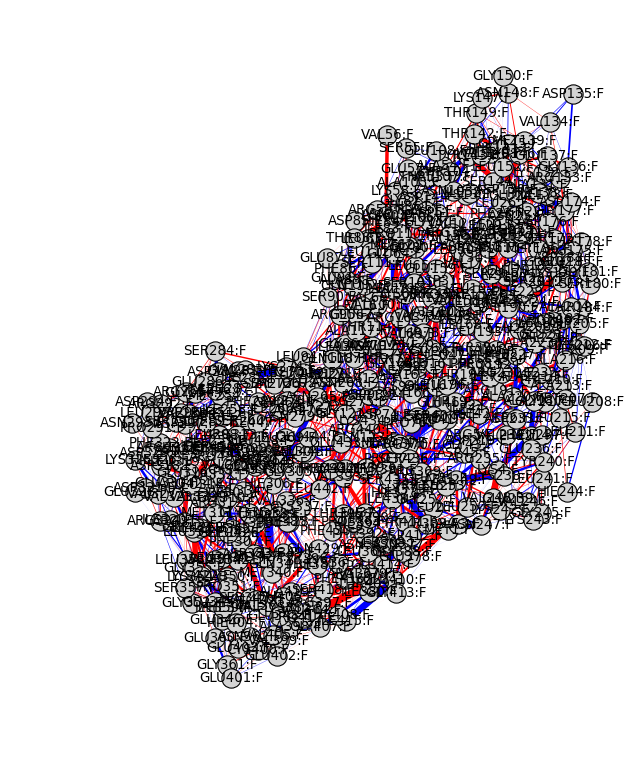

In [34]:
G = nx.from_pandas_edgelist(influences, edge_attr='C1', source='node1', target='node2')

#Generating edge colors
edge_color = ['b' if weight <= 0 else 'r' for weight in influences['C1'].values]
# And edge width
edge_width = influences['C1'].abs().values
edge_width /= 0.1 * max(edge_width)
fig, axes = plt.subplots(1, 1, figsize=[10, 12])
nx.draw(G, with_labels=True, node_color='lightgray', width=edge_width, edge_color=edge_color)

## A few exercices

- Try to apply a threshold to the PC1N (above)
- Produce a correlation plot of the edges of the DPCN and the PC1N
- Vizualize the networks on the protein in PyMol